#Breast Cancer Prediction Model
Teamproject by Steven Patrick, Wendi Qu, Mehul Pakhare

The goal for this project is to detect whether a patient has breast cancer or not using an MRI through binary image classification with at least 80% accuracy.
We defined a CNN model for binary classification using Keras with TensorFlow.

### Summary of the CBIS-DDSM Dataset Description:
The CBIS-DDSM (Curated Breast Imaging Subset of DDSM) dataset is a collection of medical images in JPEG format, derived from the original dataset which was 163GB in size. The resolution of the images in the CBIS-DDSM dataset has been maintained to match that of the original dataset. This dataset is primarily focused on breast imaging for mammography.

### Key Dataset Statistics:
Number of Studies: 6,775
Number of Series: 6,775
Number of Participants: 1,566 (Note: The dataset's structure results in multiple patient IDs per participant, making it appear as if there are 6,671 patients according to DICOM metadata, but there are actually 1,566 distinct participants.)
Number of Images: 10,239
Modality: MG (Mammography)
Image Size: 6 GB in JPEG format

Importing Necessary Libraries

In [293]:
#This is Machine Learning
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import pathlib
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models, layers, regularizers
import keras.utils as image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input
# tf.compat.v1.disable_eager_execution()


#This is used to import the data
import glob
import os
from os import listdir
import requests
from zipfile import ZipFile

# Randomization
import random
random.seed(0)

# small visualization
from IPython.display import display, Image

Defining a function to plot training and test metrics.


In [253]:
# Stole this from homework 8
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """
    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

Defining a function to print a confusion matrix.


In [254]:
def print_conf_mtx(model, classes=None):
    """ Print a confusion matrix (two classes only). """

    y_pred = create_y_pred(model)

    if classes is None:
        classes = ['neg', 'pos']

    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left       = '{:<10s}'.replace('10', str(n))
    right      = '{:>10s}'.replace('10', str(m))
    big_center = '{:^20s}'.replace('20', str(m*2))

    cm = confusion_matrix(y_test, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))

In [255]:
def create_y_pred(model):
  y_pred = model.predict(X_test)

  for i in range (len(y_pred)):
    if y_pred[i] > 0.5:
      y_pred[i] = 1
    else:
      y_pred[i] = 0

  return y_pred

Defining a function to create a gradcam and to show the predicted label of an image.

In [256]:
#GradCam (https://stackoverflow.com/questions/58322147/how-to-generate-cnn-heatmaps-using-built-in-keras-in-tf2-0-tf-keras) with some chatgpt help
def visualize_heatmap(model, input_layer_name, output_layer_name):
    # Get a random image
    random_index = np.random.randint(0, len(X_test))
    random_image = X_test[random_index]
    random_label = y_test[random_index]

    # Reshape the image to match the model's input shape
    random_image_reshaped = np.expand_dims(random_image, axis=0)

    # Get the specified input and output layers
    input_layer = model.get_layer(input_layer_name)
    output_layer = model.get_layer(output_layer_name)

    # Create a sub-model for heatmap generation
    heatmap_model = models.Model([model.inputs], [output_layer.output, model.output])

    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(random_image_reshaped)
        loss = predictions[:, tf.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    max_heat = tf.reduce_max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    # Overlay the heatmap on the original image
    heatmap_array = tf.keras.backend.eval(heatmap)
    heatmap_array = np.squeeze(heatmap_array)

    # Add an extra dimension to heatmap_array
    heatmap_array = np.expand_dims(heatmap_array, axis=-1)

    # Resize the heatmap to match the original image size
    heatmap_resized = tf.image.resize(heatmap_array, (random_image.shape[0], random_image.shape[1]))
    heatmap_resized = tf.keras.backend.eval(heatmap_resized)
    heatmap_resized = np.squeeze(heatmap_resized)

    # Make a prediction using the trained model
    prediction = model.predict(random_image_reshaped)

    # Convert the prediction to a binary label (0 or 1)
    predicted_label = 1 if prediction > 0.5 else 0

    # Plot the original image with the actual and predicted labels as the title
    plt.subplot(1, 2, 1)
    plt.imshow(random_image)
    plt.axis('off')
    plt.title(f"Actual Label: {random_label}, Predicted Label: {predicted_label}")

    # Plot the heatmap overlay
    plt.subplot(1, 2, 2)
    plt.imshow(random_image, cmap='gray')  # Display the original image in grayscale
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.7)  # Adjust alpha to control the overlay intensity
    plt.title('Original Image with Heatmap Overlay')
    plt.axis('off')  # Remove axis on the heatmap

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()


# 1. Data preparation

### Summary of the CBIS-DDSM Dataset Description:
The CBIS-DDSM (Curated Breast Imaging Subset of DDSM) dataset is a collection of medical images in JPEG format, derived from the original dataset which was 163GB in size. The resolution of the images in the CBIS-DDSM dataset has been maintained to match that of the original dataset. This dataset is primarily focused on breast imaging for mammography.

### Key Dataset Statistics:
Number of Studies: 6,775
Number of Series: 6,775
Number of Participants: 1,566 (Note: The dataset's structure results in multiple patient IDs per participant, making it appear as if there are 6,671 patients according to DICOM metadata, but there are actually 1,566 distinct participants.)
Number of Images: 10,239
Modality: MG (Mammography)
Image Size: 6 GB in JPEG format

## Getting the data

In [257]:
#Got this from ChatGPT

# Define the GitHub repository URL
repo_url = 'https://github.com/StevenHPatrick/breastCancerData/archive/94de9300f0851b14430654cd36089af864e6017b.zip'

# Specify the local path to save the downloaded file
zip_file_path = 'breast_cancer_data.zip'

# Specify the target directory
output_dir = 'breast_cancer_data'

# Check if the target directory already exists
if not os.path.exists(output_dir):
    # Download the dataset from GitHub
    response = requests.get(repo_url)
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)

    # Extract the contents of the ZIP file
    extracted_path = 'breastCancerData-94de9300f0851b14430654cd36089af864e6017b'
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    # Adjust the path to include the additional subdirectory
    dataset_path = os.path.join(extracted_path, 'breastCancerData-94de9300f0851b14430654cd36089af864e6017b')

    # Create the 'breast_cancer_data' directory
    os.makedirs(output_dir)

    # Move the contents to 'breast_cancer_data' directory
    for item in os.listdir(dataset_path):
        s = os.path.join(dataset_path, item)
        d = os.path.join(output_dir, item)
        os.rename(s, d)

# Now, breast_img will contain the paths to the images in 'breast_cancer_data'
breast_img = glob.glob(os.path.join(output_dir, 'archive/IDC_regular_ps50_idx5/**/*.png'), recursive=True)




## Exploring the data

Displaying the first 3 images in the dataset.

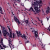

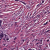

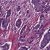

In [258]:
# Display the first 3 images
for img_path in breast_img[:3]:
    display(Image(filename=img_path))

Categorizing images into cancerous and non cancerous.


In [259]:
non_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_img.append(img)

    elif img[-5] == '1' :
        can_img.append(img)
breast_img[0]

'breast_cancer_data/archive/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2301_y2801_class1.png'

Calculating and printing the number of benign and malignant patients.

In [260]:
patients = [len(non_img), len(can_img)]

total_img_num = patients[0] + patients[1]

print('Number of benign patients: {}' .format(patients[0]))
print('Number of malignant patients: {}' .format(patients[1]))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign patients: 198738
Number of malignant patients: 78786
Total Number of Images : 277524


Bar Chart for Patient Distribution:

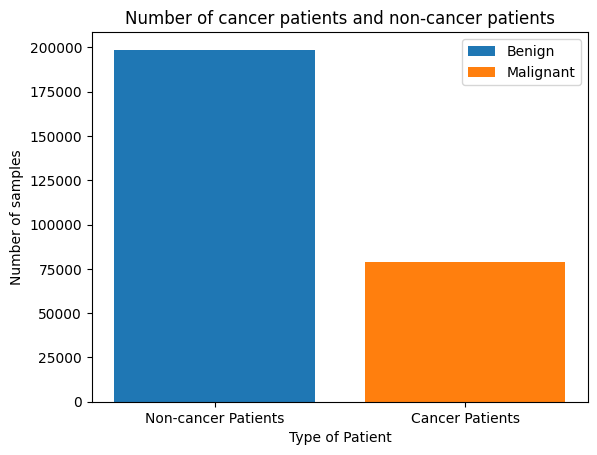

In [261]:
plt.bar("Non-cancer Patients", patients[0], label = 'Benign')
plt.bar("Cancer Patients", patients[1], label = 'Malignant')
plt.ylabel("Number of samples")
plt.xlabel("Type of Patient")
plt.title("Number of cancer patients and non-cancer patients")
plt.legend()
plt.show();

Pie Chart for Patient Distribution:

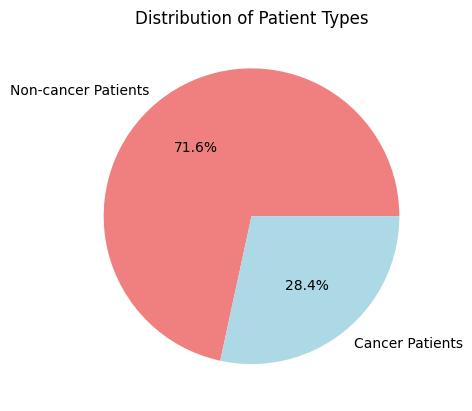

In [262]:
# Written by chatgpt
labels = ['Non-cancer Patients', 'Cancer Patients']
sizes = [patients[0], patients[1]]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.title("Distribution of Patient Types")
plt.show()

We have 277,534 images, which is a substantial amount for training. Additionally, the pie graph above illustrates significant data inequality between cancer and non-cancer images. This imbalance can lead to a biased model, so we plan to sample an even number from both categories. This approach ensures a balanced dataset and provides a more manageable amount of data for the scope of this project.

# Preprocessing the data

Randomly selecting 25,000 images from each category.


In [263]:
non_img = np.array(non_img)
can_img = np.array(can_img)

# Generate random indices
fivek_no_cancer_indices = np.random.randint(0, len(non_img), 25000)
fivek_cancer_indices = np.random.randint(0, len(can_img), 25000)

# Use boolean indexing to copy the selected images
fivek_no_cancer = non_img[fivek_no_cancer_indices]
fivek_cancer = can_img[fivek_cancer_indices]

Printing the number of cancer patients and non-cancer patients.

In [264]:
patients = [len(fivek_no_cancer), len(fivek_cancer)]

total_img_num = patients[0] + patients[1]

print('Number of benign patients: {}' .format(patients[0]))
print('Number of malignant patients: {}' .format(patients[1]))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign patients: 25000
Number of malignant patients: 25000
Total Number of Images : 50000


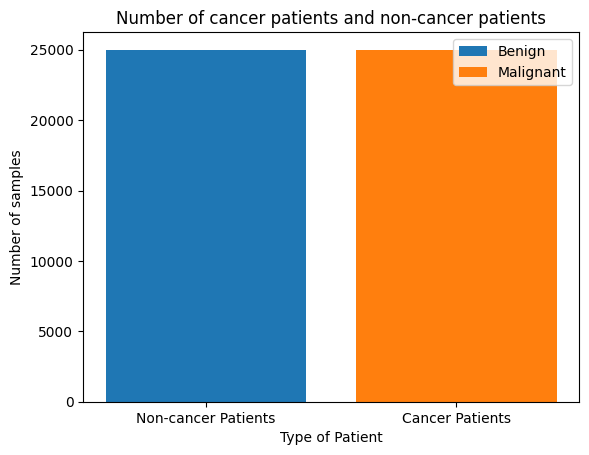

In [265]:
plt.bar("Non-cancer Patients", patients[0], label = 'Benign')
plt.bar("Cancer Patients", patients[1], label = 'Malignant')
plt.ylabel("Number of samples")
plt.xlabel("Type of Patient")
plt.title("Number of cancer patients and non-cancer patients")
plt.legend()
plt.show();

This is a more managable size to start training on. We will look at increasing the dataset later one.

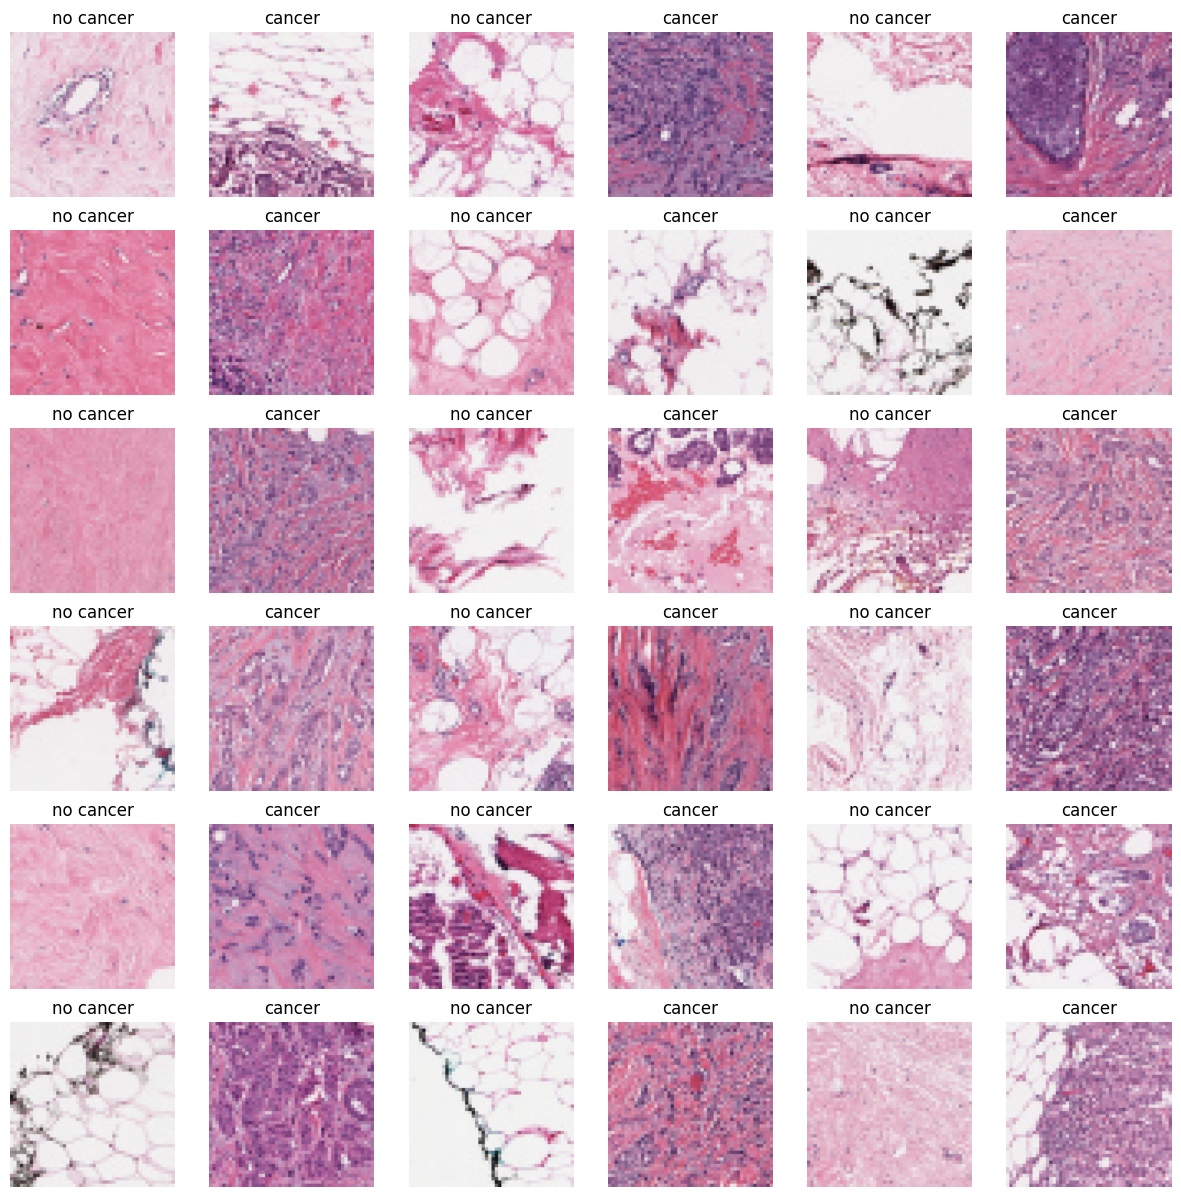

In [266]:
#Took this code from a kaggle notebook because it looked too cool. Also, it confirms that our dataset is images.

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(fivek_no_cancer), 18)
some_can = np.random.randint(0, len(fivek_cancer), 18)

s = 0
for num in some_non:

        img = image.load_img((fivek_no_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

s = 1
for num in some_can:

        img = image.load_img((fivek_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
plt.show()


# Processing the data

Function to Process the data.

In [267]:
def preprocess_images(image_paths, target_size=(100, 100)):
    """Normalize and resize images"""
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values to the range [0, 1].
        images.append(img_array)
    return np.array(images)

In [268]:
# Preprocess no cancer images
fivek_no_cancer_images = preprocess_images(fivek_no_cancer)

# Preprocess cancer images
fivek_cancer_images = preprocess_images(fivek_cancer)

# Combine the datasets
X = np.concatenate([fivek_no_cancer_images, fivek_cancer_images])

# Create labels for the dataset (0 for no cancer, 1 for cancer). This information was obtained from looking through the Kaggle's discussions
y = np.concatenate([np.zeros(len(fivek_no_cancer_images)), np.ones(len(fivek_cancer_images))])



Performing test train split.

In [269]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [270]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (40000, 100, 100, 3)
X_test shape: (10000, 100, 100, 3)
y_train shape: (40000,)
y_test shape: (10000,)


Violin Plot for Image Pixel Values:

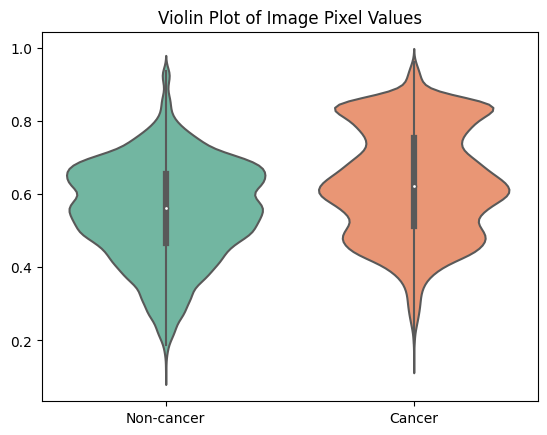

In [271]:
pixel_values = pd.DataFrame({'Non-cancer': X_train[0].flatten(), 'Cancer': X_train[1].flatten()})
sns.violinplot(data=pixel_values, palette='Set2')
plt.title("Violin Plot of Image Pixel Values")
plt.show()

The violin plot suggests that the cancer images have a higher pixel value distribution than the non-cancer images. This could reduce the accuracy of the machine learning model.

Histogram for Image Intensity Distribution:

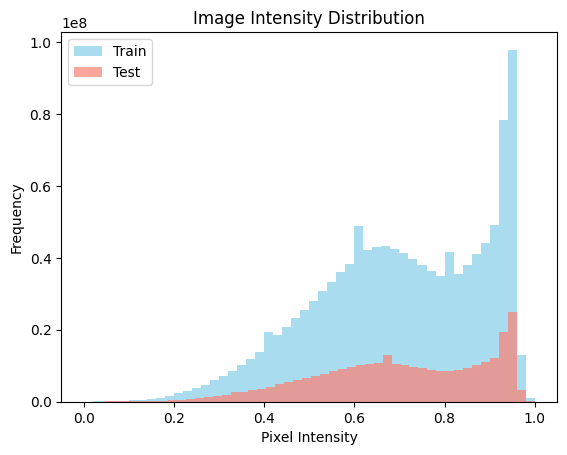

In [272]:
plt.hist(X_train.flatten(), bins=50, color='skyblue', alpha=0.7, label='Train')
plt.hist(X_test.flatten(), bins=50, color='salmon', alpha=0.7, label='Test')
plt.title("Image Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The histogram shows a wider distribution of pixel intensities in the training data, suggesting a variety of intensities, while the testing data is narrower and skewed towards higher intensities. This discrepancy could lead to model bias or overfitting.

# Creating the models

##Creating the Baseline model.

We created this basic model to compared against. This was a simple mode created with chatGPT.

In [273]:
# created by ChatGPT
# Input layer
input_layer = layers.Input(shape=(100, 100, 3), name = "input")

# Convolutional layers
x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', name = "heatmap_creator")(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten the output
x = layers.Flatten()(x)

# Dense layers
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = layers.Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Create the model
baseline = models.Model(inputs=input_layer, outputs=x)

# Compile the model
baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [274]:
# Display the model summary
baseline.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 heatmap_creator (Conv2D)    (None, 21, 21, 128)       7385

## Training the Baseline model

In [275]:
# Train the model
history_baseline = baseline.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
39968/40000 [============================>.] - ETA: 0s - loss: 0.4910 - accuracy: 0.7754

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40000/40000 [==============================] - 9s 224us/sample - loss: 0.4909 - accuracy: 0.7755 - val_loss: 0.4223 - val_accuracy: 0.8146
Epoch 2/50
40000/40000 [==============================] - 9s 216us/sample - loss: 0.4406 - accuracy: 0.8083 - val_loss: 0.4265 - val_accuracy: 0.8085
Epoch 3/50
40000/40000 [==============================] - 9s 224us/sample - loss: 0.4174 - accuracy: 0.8207 - val_loss: 0.3956 - val_accuracy: 0.8268
Epoch 4/50
40000/40000 [==============================] - 9s 219us/sample - loss: 0.4055 - accuracy: 0.8278 - val_loss: 0.4154 - val_accuracy: 0.8201
Epoch 5/50
40000/40000 [==============================] - 9s 218us/sample - loss: 0.3929 - accuracy: 0.8344 - val_loss: 0.4131 - val_accuracy: 0.8125
Epoch 6/50
40000/40000 [==============================] - 9s 217us/sample - loss: 0.3841 - accuracy: 0.8376 - val_loss: 0.3826 - val_accuracy: 0.8360
Epoch 7/50
40000/40000 [==============================] - 9s 218us/sample - loss: 0.3777 - accuracy: 0.8417 - v

##Visualizing the Baseline model

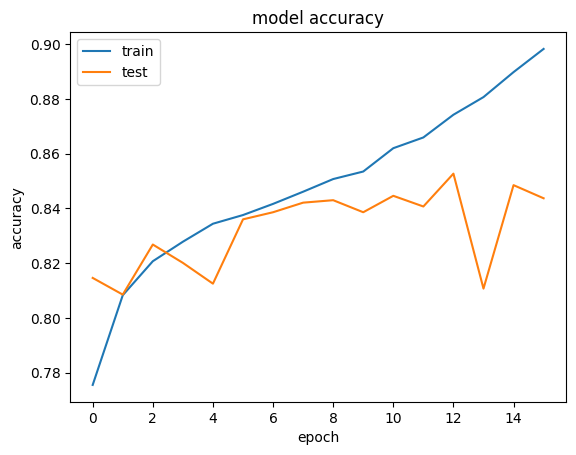

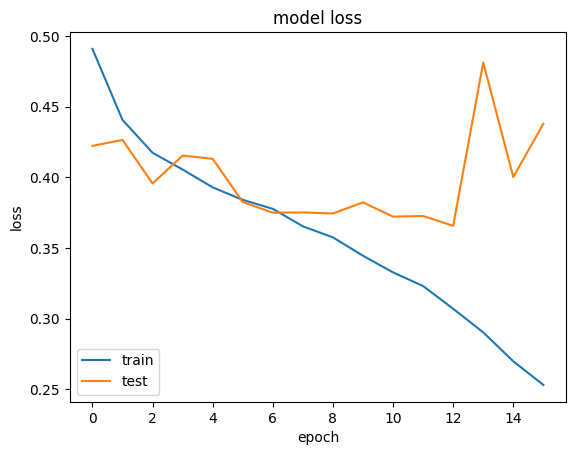

In [276]:
# Plot training history
plot_metric(history_baseline, 'accuracy')
plot_metric(history_baseline, 'loss')

In [277]:
#creates a confusion matrix
print_conf_mtx(baseline, classes=['not cancer', 'cancer'])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


               predicted      
actual    not cancer    cancer
not cancer      4235       787
cancer           686      4292


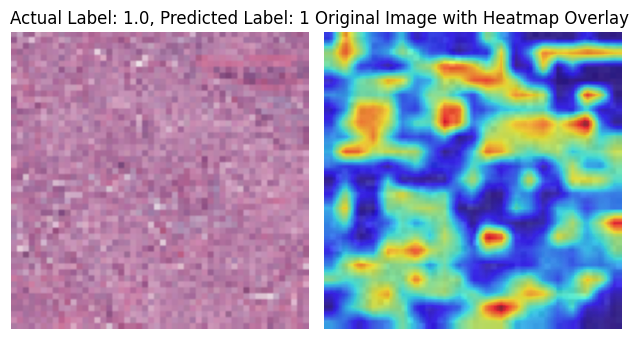

In [291]:
# Call the function to visualize the heatmap
visualize_heatmap(baseline, "input", "heatmap_creator")

The baseline model completely surprised us by achieving our goal of reaching 80% accuracy on the first run. As a result, any further improvements on top of this model are just icing on the cake. We have also created a heatmap to visualize what the model focuses on during training. It randomly selects an image each time.

##Creating a more complex model

We created a more complex model that has batch normalization, global average pooling, and reduce learning rate on plateu.

In [279]:
#Created by ChatGPT
# Input layer
input_layer = layers.Input(shape=(100, 100, 3), name = "input")
# x = data_augmentation(input_layer)

conv1 = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(input_layer)
batch1 = layers.BatchNormalization()(conv1)
x = layers.Activation('relu')(batch1)
pool1 = layers.MaxPooling2D((2, 2))(x)

conv2 = layers.Conv2D(128, (3, 3), padding='same',use_bias=False)(pool1)
batch2 = layers.BatchNormalization()(conv2)
x = layers.Activation('relu')(batch2)
pool2 = layers.MaxPooling2D((2, 2))(x)

conv3 = layers.Conv2D(128, (3, 3), padding='same',use_bias=False, name = "heatmap_creator")(pool2)
batch3 = layers.BatchNormalization()(conv3)
x = layers.Activation('relu')(batch3)
pool3 = layers.MaxPooling2D((2, 2))(x)


x = layers.GlobalAveragePooling2D()(pool3)

# Dense layers
dense1 = layers.Dense(128, activation='relu')(x)
dropout = layers.Dropout(0.3)(dense1)
output_layer = layers.Dense(1, activation='sigmoid')(dropout)  # Output layer with sigmoid activation for binary classification

# Create the model
gptcode = models.Model(inputs=input_layer, outputs=output_layer)


# Compile the model
gptcode.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.000001,verbose=1)

In [280]:
gptcode.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 128)     3456      
                                                                 
 batch_normalization (Batch  (None, 100, 100, 128)     512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 100, 100, 128)     0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 50, 50, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 128)       1474

Despite the model having more components added to it, it is smaller than the baseline. Hopefully, it is just as accurate.

## Training the more complex model

In [281]:
gpthistory = gptcode.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping,reduce_lr])

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
39968/40000 [============================>.] - ETA: 0s - loss: 0.4047 - accuracy: 0.8250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40000/40000 [==============================] - 26s 651us/sample - loss: 0.4048 - accuracy: 0.8250 - val_loss: 0.4069 - val_accuracy: 0.8276 - lr: 0.0010
Epoch 2/50
40000/40000 [==============================] - 25s 622us/sample - loss: 0.3700 - accuracy: 0.8439 - val_loss: 0.8925 - val_accuracy: 0.6922 - lr: 0.0010
Epoch 3/50
40000/40000 [==============================] - 25s 634us/sample - loss: 0.3588 - accuracy: 0.8486 - val_loss: 0.3694 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/50
40000/40000 [==============================] - 25s 625us/sample - loss: 0.3498 - accuracy: 0.8511 - val_loss: 0.5914 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 5/50
40000/40000 [==============================] - 25s 630us/sample - loss: 0.3416 - accuracy: 0.8570 - val_loss: 0.3764 - val_accuracy: 0.8374 - lr: 0.0010
Epoch 6/50
40000/40000 [==============================] - 25s 626us/sample - loss: 0.3371 - accuracy: 0.8588 - val_loss: 0.5089 - val_accuracy: 0.7523 - lr: 0.0010
Epoch 7/50
40000/40000 [===

##Visualizing the more complex model

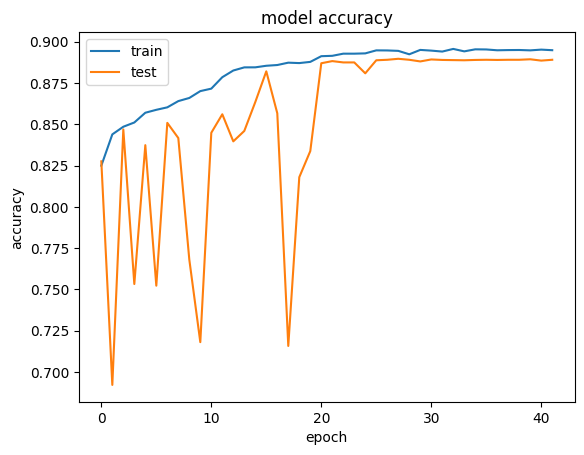

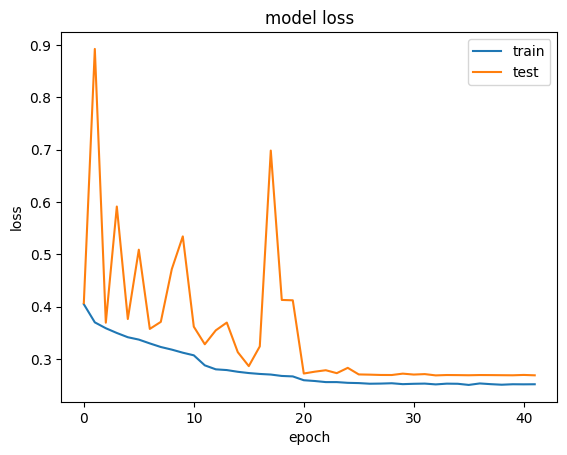

In [282]:
# Plot training history
plot_metric(gpthistory, 'accuracy')
plot_metric(gpthistory, 'loss')

In [283]:
print_conf_mtx(gptcode, classes=['not cancer', 'cancer'])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


               predicted      
actual    not cancer    cancer
not cancer      4369       653
cancer           458      4520


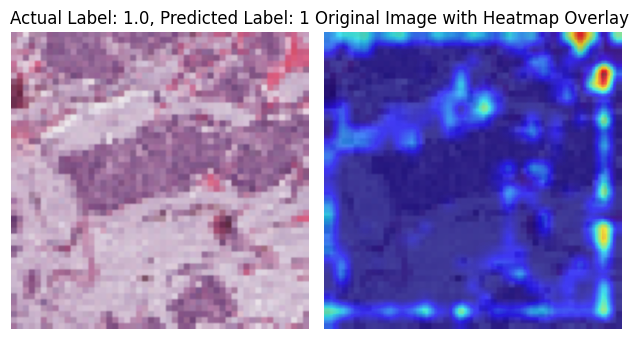

In [304]:
# Call the function to visualize the heatmap
visualize_heatmap(gptcode, "input", "heatmap_creator")

This model ran for much longer than the baseline, despite having fewer trainable parameters. However, it was also far more accurate, almost reaching 90% accuracy.

##Creating an import model

The last thing we wanted to test was creating a model that imported its lower layers from a different pretrained model. In this case, we chose VGG16.

In [299]:
#ChatGPT helped to create this
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False
# Create the model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# Additional Dense layers
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.3)(x)
# Your output layer
output_layer = layers.Dense(1, activation='sigmoid')(x)
VGG16_import = models.Model(inputs=base_model.input, outputs=output_layer)
# Compile the model
VGG16_import.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])
VGG16_import.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0  

## Training the import model

In [300]:
VGG16_import_history = VGG16_import.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping,reduce_lr])

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - ETA: 0s - loss: 0.6264 - accuracy: 0.7635

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40000/40000 [==============================] - 20s 506us/sample - loss: 0.6264 - accuracy: 0.7635 - val_loss: 0.5284 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 2/50
40000/40000 [==============================] - 19s 483us/sample - loss: 0.5210 - accuracy: 0.7766 - val_loss: 0.5041 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 3/50
40000/40000 [==============================] - 19s 486us/sample - loss: 0.5121 - accuracy: 0.7797 - val_loss: 0.5111 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 4/50
40000/40000 [==============================] - 20s 488us/sample - loss: 0.5066 - accuracy: 0.7846 - val_loss: 0.4894 - val_accuracy: 0.7951 - lr: 0.0010
Epoch 5/50
40000/40000 [==============================] - 19s 482us/sample - loss: 0.5024 - accuracy: 0.7861 - val_loss: 0.5160 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 6/50
40000/40000 [==============================] - 19s 482us/sample - loss: 0.4994 - accuracy: 0.7871 - val_loss: 0.4869 - val_accuracy: 0.7965 - lr: 0.0010
Epoch 7/50
40000/40000 [===

##Visualizing the import model

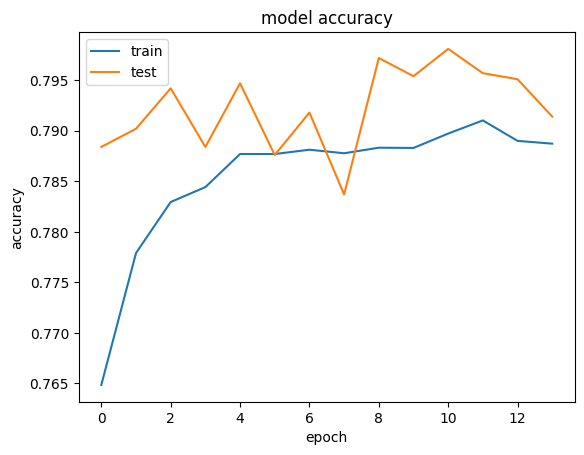

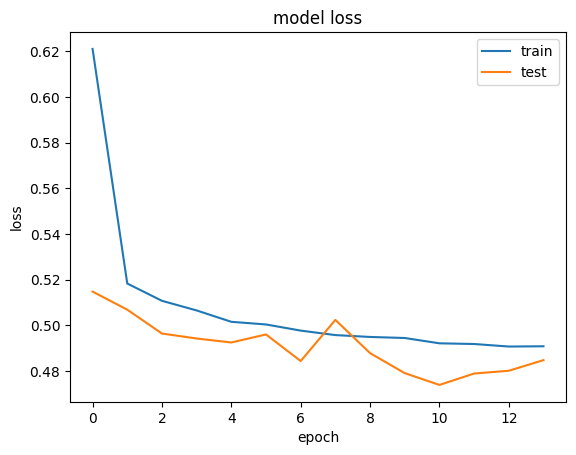

In [297]:
# Plot training history
plot_metric(VGG16_import_history, 'accuracy')
plot_metric(VGG16_import_history, 'loss')

In [298]:
print_conf_mtx(gptcode, classes=['not cancer', 'cancer'])

               predicted      
actual    not cancer    cancer
not cancer      4369       653
cancer           458      4520


Before analyzing this model, we cannot use the heatmap with it since we don't know the layer names in the imported model. However, that doesn't stop us from seeing how this model performed worse than our baseline. We suspect this is because our custom-built models are designed for detecting cancer, while this one isn't.

# Summary

In conclusion, we trained three different models: a baseline, a more complex model, and an imported model. All three were run to detect cancer in 100x100 images. We aimed to achieve an accuracy above 80% and successfully did so for two out of the three models we created.